# lgb reference
#   - https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
#   - https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py
#   - https://github.com/Microsoft/LightGBM/blob/master/docs/Features.rst
#   - https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
#   - https://sites.google.com/view/lauraepp/parameters

In [ ]:
from notebooks import *
print_sys_info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic
platform:
  machine: x86_64
  node: Dan-B.local
  processor: i386
  release: 15.6.0
  system: Darwin
  version: 'Darwin Kernel Version 15.6.0: Thu Jun 23 18:25:34 PDT 2016; root:xnu-3248.60.10~1/RELEASE_X86_64'
cpu: 8
mem: 16g
swap: 16g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[02:39:02.514] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
recs_at_least, num_species, num_recs =  20, 168,  20    # ca[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # (old 'recs')
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  50   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  20   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  10   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  5    # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
com_names          334/35236 (sp/recs)
(downloaded)       334/35232 (sp/recs)
recs_at_least      296/34846 (sp/recs)
num_species        168/19640 (sp/recs)


num_recs            168/3360 (sp/recs)
recs ≥ 2            168/3360 (sp/recs)


'sp[168], recs[3360]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,94080,3360,3360,1,NaN,NaN,True,True,True,True,True
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
id,int64,94080,3360,3360,3360,213283.439,108055.964,1133,138144,193564,308285,416744
sci_name,category,227200,3360,3360,168,NaN,NaN,Anser albifrons,Gelochelidon nilotica,Vireo olivaceus,Parkesia noveboracensis,Spinus tristis
com_name,category,220320,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
subspecies,object,169603,3360,3360,205,NaN,NaN,,,,,zaboria
recordist,object,211728,3360,3360,291,NaN,NaN,AJ Knue,Frank Lambert,Matthias Feuersenger,Peter Boesman,tetiaroa
country,object,203063,3360,3360,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,316516,3360,3360,1740,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Desert Beeline Highway, Maricopa County, Arizona","May Lake, Yosemite NP, California","Sabine Nature Trail loop, Cameron Parish, Louisiana","west of Thorp, WA"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
COGA,205189,True,COGA,207451,Gallinula galeata,Common Gallinule,sandvicensis,Ross Gallardy,United States,"Kailua, Honolulu County, Hawaii",21.4,-158.0,call,B,2014-12-21 00:00:00,07:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/207451,//www.xeno-canto.org/207451/download
INDO,18832,True,INDO,398616,Columbina inca,Inca Dove,,Manuel Grosselet,Mexico,Lomas de Bezares Miguel Hidalgo Mexico city,19.4,-99.2,song,B,2018-01-07 00:00:00,08:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/398616,//www.xeno-canto.org/398616/download
EWPW,223194,True,EWPW,188611,Antrostomus vociferus,Eastern Whip-poor-will,,David Jonas Weber,United States,"Gravelly Hill Rd., Salem County, New Jersey",39.5,-75.4,song,C,2014-07-25 00:00:00,05:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/188611,//www.xeno-canto.org/188611/download
NUWO,113835,True,NUWO,301366,Picoides nuttallii,Nuttall's Woodpecker,,Denise Wight,United States,"Moraga, Contra Costa County, California",37.8,-122.0,"Hawk mobbing call, alarm call",C,2016-01-25 00:00:00,10:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/301366,//www.xeno-canto.org/301366/download
BBWO,80808,True,BBWO,335436,Picoides arcticus,Black-backed Woodpecker,,Lance A. M. Benner,United States,"Blackrock Trailhead, Tulare County, California",36.2,-118.0,"drumming, male",no score,2016-09-17 00:00:00,16:41,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/335436,//www.xeno-canto.org/335436/download
HUVI,117936,True,HUVI,297126,Vireo huttoni,Hutton's Vireo,,Paul Marvin,United States,"Kickapoo Cavern State Park, Brackettville, Texas",29.6,-100.0,song,C,2012-04-08 00:00:00,07:58,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/297126,//www.xeno-canto.org/297126/download
MGWA,89731,True,MGWA,326299,Geothlypis tolmiei,MacGillivray's Warbler,,Lance A. M. Benner,United States,"Buckhorn Campground, San Gabriel Mountains, Los Angeles County, California",34.3,-118.0,"male, song",no score,2016-06-28 00:00:00,10:49,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/326299,//www.xeno-canto.org/326299/download
PUFI,159786,True,PUFI,254326,Haemorhous purpureus,Purple Finch,,Iain,Canada,"Algonquin Highlands, Haliburton County, Ontario",45.3,-78.8,song,C,2015-06-27 00:00:00,11:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/254326,//www.xeno-canto.org/254326/download
CAFI,46804,True,CAFI,369971,Haemorhous cassinii,Cassin's Finch,,Eric DeFonso,United States,"Dunton Rd area, San Juan National Forest, Dolores County, Colorado",37.8,-108.0,song,A,2016-06-28 00:00:00,15:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/369971,//www.xeno-canto.org/369971/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    # xcs_paths[:2],
)

3360

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,171360,3360,3360,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
species_com_name,category,219160,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
species_query,object,178080,3360,3360,168,NaN,NaN,ACWO,CONI,LASP,RIRA,YRWA
duration_s,float64,80640,3360,3360,3054,5.430e+01,7.031e+01,0.697,14.4,31.8,65.4,940
samples_mb,float64,80640,3360,3360,3055,2.286e+00,2.958e+00,0.0293,0.604,1.34,2.76,39.5
samples_n,int64,94080,3360,3360,3055,1.198e+06,1.551e+06,15368,316510,701190,1444435,20731931
basename,object,181440,3360,3360,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,242680,3360,3360,168,NaN,NaN,Greater White-fronted Goose - GWFG,Gull-billed Tern - GBTE,Red-eyed Vireo - REVI,Northern Waterthrush - NOWA,American Goldfinch - AMGO


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,GWFG,Greater White-fronted Goose,GWFG,23.7,0.997,522850,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149379/audio,xc/data/GWFG/149379/audio.mp3
1,xc,GWFG,Greater White-fronted Goose,GWFG,18.3,0.770,403780,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276918/audio,xc/data/GWFG/276918/audio.mp3
2,xc,GWFG,Greater White-fronted Goose,GWFG,45.0,1.890,991296,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/210100/audio,xc/data/GWFG/210100/audio.mp3
3,xc,GWFG,Greater White-fronted Goose,GWFG,17.6,0.738,387072,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/323113/audio,xc/data/GWFG/323113/audio.mp3
4,xc,GWFG,Greater White-fronted Goose,GWFG,24.0,1.010,528142,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276919/audio,xc/data/GWFG/276919/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plot below (7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Greater White-fronted Goose - GWFG,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
1,Gadwall - GADW,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
2,American Wigeon - AMWI,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
3,Mallard - MALL,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
4,Green-winged Teal - GWTE,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
5,California Quail - CAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
6,Gambel's Quail - GAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7,Sooty Grouse - SOGR,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8,Wild Turkey - WITU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9,Common Loon - COLO,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20


In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# Make data
X, y = Search.Xy(recs)
classes = np.sort(np.unique(y))
n_classes = len(classes)
yi = lambda y: np.array([list(classes).index(_y) for _y in y])  # lgb api wants num labels, not str labels
(X_train, X_test, y_train, y_test) = sk.model_selection.train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
)
display(
    (X.shape, y.shape),
    y[:5],
    (X_train.shape, y_train.shape),
    (X_test.shape, y_test.shape),
)

((3360, 1500), (3360,))

array(['GWFG', 'GWFG', 'GWFG', 'GWFG', 'GWFG'], dtype='<U4')

((2688, 1500), (2688,))

((672, 1500), (672,))

In [ ]:
# Make lgb data
lgb_train = lgb.Dataset(X_train, yi(y_train), free_raw_data=False)
lgb_test = lgb.Dataset(X_test, yi(y_test), free_raw_data=False)

In [ ]:
lgb_train_kwargs = dict(
    # lgb.train args that feel like they belong in lgb_params instead

    num_boost_round=100,
    #   - Default: 100
    #   - "Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems"

    # early_stopping_rounds=None,
    #   - Default: None (disabled)
    #   - "Activates early stopping. The model will train until the validation score stops improving."
    #   - "Requires at least one validation data and one metric. If there's more than one, will check all of them except
    #     the training data."
    #   - "If early stopping occurs, the model will add ``best_iteration`` field"

    # learning_rates=None,
    #   - Default: None
    #   - Dynamic learning rate
    #   - learning_rates: list, callable or None, optional (default=None)
    #       List of learning rates for each boosting round or a customized function that calculates ``learning_rate``
    #       in terms of current number of round (e.g. yields learning rate decay).

)
lgb_params = dict(
    # https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst

    # Core Parameters
    objective='multiclass',
    #   - Must also set num_class
    boosting='gbdt',
    # num_iterations=100,
    #   - [Deprecated: moved to .train]
    learning_rate=.01,
    # num_leaves=31,
    # tree_learner='serial',
    #   - Single machine, multicore: 'serial' (default)
    #   - [ignore] Distributed training: 'feature' | 'data' | 'voting'
    #   - https://github.com/Microsoft/LightGBM/blob/master/docs/Parallel-Learning-Guide.rst
    # num_threads=0,
    # device_type='cpu',
    #   - 'cpu' (default) | 'gpu'
    #   - Would gpu need rebuild? https://github.com/Microsoft/LightGBM/blob/master/docs/Installation-Guide.rst#build-gpu-version
    #   - "Note: it is recommended to use the smaller max_bin (e.g. 63) to get the better speed up" (below)
    #   - "Note: for the faster speed, GPU uses 32-bit float point to sum up by default, so this may affect the
    #     accuracy for some tasks. You can set gpu_use_dp=true to enable 64-bit float point, but it will slow down
    #     the training"
    seed=0,
    #   - Generates all seeds (e.g. data_random_seed)

    # Learning Control Parameters
    # max_depth=-1,
    #   - -1 = no limit
    min_data_in_leaf=1,
    #   - 20 (default) is too big when data is small [https://github.com/Microsoft/LightGBM/issues/907]
    # bagging_fraction=1.0,
    #   - Sample data per tree (without replacement)
    #   - Requires bagging_freq > 0
    # bagging_freq=0,
    #   - Bag at every kth iteration (0 = disable)
    #   - Requires bagging_fraction < 1
    # feature_fraction=1.0,
    #   - Sample features per tree
    # early_stopping_round=0,
    #   - [Deprecated: moved to .train]
    # max_delta_step=0.0,
    #   - "used to limit the max output of tree leaves"
    #   - "<= 0 means no constraint"
    #   - "the final max output of leaves is learning_rate * max_delta_step"
    # lambda_l1=0.0,
    #   - L1 regularization
    # lambda_l2=0.0,
    #   - L2 regularization
    # min_gain_to_split=0.0,
    #   - "the minimal gain to perform split"

    # IO Parameters
    #   - TODO Grok more of these: https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst#io-parameters
    verbosity=1,
    max_bin=63,
    #   - Default: 255
    #   - "it is recommended to use the smaller max_bin (e.g. 63) to get the better speed up" (from cpu/gpu)
    #   - "max number of bins that feature values will be bucketed in"
    #   - "small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)"
    #   - "LightGBM will auto compress memory according to max_bin. For example, LightGBM will use uint8_t for
    #     feature value if max_bin=255"
    # min_data_in_bin=3,
    #   - "use this to avoid one-data-one-bin (potential over-fitting)"
    # bin_construct_sample_cnt=200000,
    #   - "number of data that sampled to construct histogram bins"
    #   - "setting this to larger value will give better training result, but will increase data loading time"
    #   - "set this to larger value if data is very sparse"
    #   - TODO Tune with len(X)
    # two_round=False,
    #   - "set this to true if data file is too big to fit in memory"
    # save_binary=False,
    #   - "save the dataset (including validation data) to a binary file. This speed ups the data loading for the next time"
    # enable_load_from_binary_file=True,
    #   - "set this to true to enable autoloading from previous saved binary datasets"

    # Objective Parameters
    num_class=n_classes,
    #   - Default: 1
    #   - Required for objective='multiclass'

    # Metric Parameters
    #   - [ignore]

    # Network Parameters
    #   - [ignore]

    # GPU Parameters
    #   - [ignore]

)

In [ ]:
evals_result = {}
gbm = lgb.train(
    **lgb_train_kwargs,
    params=lgb_params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'test'],
    evals_result=evals_result,
    verbose_eval=1,
    #   - Print every n rounds
    keep_training_booster=True,
    #   - Default: False
    #   - Whether to retain memory for further training [https://github.com/Microsoft/LightGBM/issues/668]
    #   - FIXME .save_model only includes params if keep_training_booster=True
    #       - Seems like it was intended to include params in both cases? [https://github.com/Microsoft/LightGBM/issues/1364]
)
display(
    # evals_result,  # evals_result['test']['multi_logloss']: np.ndarray, same as the verbose output
)

[1]	train's multi_logloss: 4.28681	test's multi_logloss: 5.03845


[2]	train's multi_logloss: 3.92422	test's multi_logloss: 5.00213


[3]	train's multi_logloss: 3.67192	test's multi_logloss: 4.97832


[4]	train's multi_logloss: 3.47592	test's multi_logloss: 4.96078


[5]	train's multi_logloss: 3.31485	test's multi_logloss: 4.94589


[6]	train's multi_logloss: 3.17778	test's multi_logloss: 4.93328


[7]	train's multi_logloss: 3.05832	test's multi_logloss: 4.92281


[8]	train's multi_logloss: 2.95236	test's multi_logloss: 4.91377


[9]	train's multi_logloss: 2.8571	test's multi_logloss: 4.9056


[10]	train's multi_logloss: 2.77054	test's multi_logloss: 4.89855


[11]	train's multi_logloss: 2.6912	test's multi_logloss: 4.8917


[12]	train's multi_logloss: 2.61797	test's multi_logloss: 4.88534


[13]	train's multi_logloss: 2.54996	test's multi_logloss: 4.87946


[14]	train's multi_logloss: 2.48646	test's multi_logloss: 4.87379


[15]	train's multi_logloss: 2.42693	test's multi_logloss: 4.86828


[16]	train's multi_logloss: 2.37088	test's multi_logloss: 4.86343


[17]	train's multi_logloss: 2.31793	test's multi_logloss: 4.85901


[18]	train's multi_logloss: 2.26777	test's multi_logloss: 4.85478


[19]	train's multi_logloss: 2.22011	test's multi_logloss: 4.85102


[20]	train's multi_logloss: 2.17471	test's multi_logloss: 4.84751


[21]	train's multi_logloss: 2.13138	test's multi_logloss: 4.84383


[22]	train's multi_logloss: 2.08994	test's multi_logloss: 4.84027


[23]	train's multi_logloss: 2.05022	test's multi_logloss: 4.83708


[24]	train's multi_logloss: 2.0121	test's multi_logloss: 4.83381


[25]	train's multi_logloss: 1.97546	test's multi_logloss: 4.83065


[26]	train's multi_logloss: 1.94018	test's multi_logloss: 4.82756


[27]	train's multi_logloss: 1.90618	test's multi_logloss: 4.82453


[28]	train's multi_logloss: 1.87336	test's multi_logloss: 4.82165


[29]	train's multi_logloss: 1.84165	test's multi_logloss: 4.81896


[30]	train's multi_logloss: 1.81097	test's multi_logloss: 4.81634


[31]	train's multi_logloss: 1.78128	test's multi_logloss: 4.81381


[32]	train's multi_logloss: 1.7525	test's multi_logloss: 4.8114


[33]	train's multi_logloss: 1.72458	test's multi_logloss: 4.80926


[34]	train's multi_logloss: 1.69748	test's multi_logloss: 4.80705


[35]	train's multi_logloss: 1.67115	test's multi_logloss: 4.80513


[36]	train's multi_logloss: 1.64556	test's multi_logloss: 4.80324


[37]	train's multi_logloss: 1.62066	test's multi_logloss: 4.80153


[38]	train's multi_logloss: 1.59642	test's multi_logloss: 4.79966


[39]	train's multi_logloss: 1.57281	test's multi_logloss: 4.79784


[40]	train's multi_logloss: 1.5498	test's multi_logloss: 4.7961


[41]	train's multi_logloss: 1.52736	test's multi_logloss: 4.79418


[42]	train's multi_logloss: 1.50546	test's multi_logloss: 4.79249


[43]	train's multi_logloss: 1.48409	test's multi_logloss: 4.79068


[44]	train's multi_logloss: 1.46321	test's multi_logloss: 4.78894


[45]	train's multi_logloss: 1.44282	test's multi_logloss: 4.78711


[46]	train's multi_logloss: 1.42288	test's multi_logloss: 4.78539


[47]	train's multi_logloss: 1.40338	test's multi_logloss: 4.78369


[48]	train's multi_logloss: 1.38431	test's multi_logloss: 4.78208


[49]	train's multi_logloss: 1.36564	test's multi_logloss: 4.78049


[50]	train's multi_logloss: 1.34737	test's multi_logloss: 4.77894


[51]	train's multi_logloss: 1.32947	test's multi_logloss: 4.7775


[52]	train's multi_logloss: 1.31194	test's multi_logloss: 4.77611


[53]	train's multi_logloss: 1.29476	test's multi_logloss: 4.77462


[54]	train's multi_logloss: 1.27792	test's multi_logloss: 4.77305


[55]	train's multi_logloss: 1.2614	test's multi_logloss: 4.77165


[56]	train's multi_logloss: 1.2452	test's multi_logloss: 4.77021


[57]	train's multi_logloss: 1.22931	test's multi_logloss: 4.76886


[58]	train's multi_logloss: 1.21371	test's multi_logloss: 4.76758


[59]	train's multi_logloss: 1.1984	test's multi_logloss: 4.7663


[60]	train's multi_logloss: 1.18337	test's multi_logloss: 4.76499


[61]	train's multi_logloss: 1.16861	test's multi_logloss: 4.76369


[62]	train's multi_logloss: 1.15411	test's multi_logloss: 4.76245


[63]	train's multi_logloss: 1.13987	test's multi_logloss: 4.76109


[64]	train's multi_logloss: 1.12587	test's multi_logloss: 4.75973


[65]	train's multi_logloss: 1.11211	test's multi_logloss: 4.75835


[66]	train's multi_logloss: 1.09858	test's multi_logloss: 4.75707


[67]	train's multi_logloss: 1.08528	test's multi_logloss: 4.75586


[68]	train's multi_logloss: 1.07219	test's multi_logloss: 4.75471


[69]	train's multi_logloss: 1.05933	test's multi_logloss: 4.75353


[70]	train's multi_logloss: 1.04667	test's multi_logloss: 4.75241


[71]	train's multi_logloss: 1.03421	test's multi_logloss: 4.75128


[72]	train's multi_logloss: 1.02196	test's multi_logloss: 4.7501


[73]	train's multi_logloss: 1.00989	test's multi_logloss: 4.74893


[74]	train's multi_logloss: 0.998014	test's multi_logloss: 4.7477


[75]	train's multi_logloss: 0.986321	test's multi_logloss: 4.74651


[76]	train's multi_logloss: 0.974807	test's multi_logloss: 4.74533


[77]	train's multi_logloss: 0.963468	test's multi_logloss: 4.74417


[78]	train's multi_logloss: 0.952299	test's multi_logloss: 4.74292


[79]	train's multi_logloss: 0.941297	test's multi_logloss: 4.74178


[80]	train's multi_logloss: 0.930458	test's multi_logloss: 4.7406


[81]	train's multi_logloss: 0.919778	test's multi_logloss: 4.73936


[82]	train's multi_logloss: 0.909253	test's multi_logloss: 4.73812


[83]	train's multi_logloss: 0.898881	test's multi_logloss: 4.73692


[84]	train's multi_logloss: 0.888657	test's multi_logloss: 4.7357


[85]	train's multi_logloss: 0.87858	test's multi_logloss: 4.73448


[86]	train's multi_logloss: 0.868644	test's multi_logloss: 4.73336


[87]	train's multi_logloss: 0.858848	test's multi_logloss: 4.73225


[88]	train's multi_logloss: 0.849189	test's multi_logloss: 4.73113


[89]	train's multi_logloss: 0.839663	test's multi_logloss: 4.73002


[90]	train's multi_logloss: 0.830269	test's multi_logloss: 4.72897


[91]	train's multi_logloss: 0.821002	test's multi_logloss: 4.72796


[92]	train's multi_logloss: 0.811862	test's multi_logloss: 4.72686


[93]	train's multi_logloss: 0.802845	test's multi_logloss: 4.72583


[94]	train's multi_logloss: 0.793949	test's multi_logloss: 4.72484


[95]	train's multi_logloss: 0.785172	test's multi_logloss: 4.72385


[96]	train's multi_logloss: 0.776511	test's multi_logloss: 4.72295


[97]	train's multi_logloss: 0.767964	test's multi_logloss: 4.72205


[98]	train's multi_logloss: 0.75953	test's multi_logloss: 4.72116


[99]	train's multi_logloss: 0.751205	test's multi_logloss: 4.72024


[100]	train's multi_logloss: 0.742988	test's multi_logloss: 4.71941


In [ ]:
# Num trees
num_trees = len(gbm.dump_model()['tree_info'])  # = n_classes trees * num_boost_round iterations
display(
    (n_classes, lgb_train_kwargs['num_boost_round']),  # (No good way to retrieve params from gbm)
    gbm.current_iteration(),  # Same as num_boost_round
    # gbm.best_iteration,  # 0 unless early_stopping
    num_trees,
)

(168, 100)

100

16800

In [ ]:
# Model size
gbm_str = gbm._save_model_to_string()
gbm_pickle = joblib_dumps(gbm)
display(
    humanize.naturalsize(len(gbm_str)),
    humanize.naturalsize(len(gbm_pickle)),  # Lots of redundancy because it's just a pickle of gbm._save_model_to_string()
    humanize.naturalsize(len(gzip.compress(gbm_pickle))),  # Approximate a less-redundant representation
)

'43.1 MB'

'43.1 MB'

'10.5 MB'

In [ ]:
# Show some evals
y_pred = gbm.predict(X_test)
test_evals = SearchEvals(y=y_test, classes=classes, y_scores=y_pred)
display(
    X_test.shape,
    y_pred.shape,
    test_evals.score(),
    test_evals.coverage_error(),
    test_evals.coverage_errors(),
)

(672, 1500)

(672, 168)

numpy.float64(-21.0)

numpy.float64(21.0)

array([  3.,   3.,  28.,  16.,   5.,  85.,  45.,  31.,  23., 162.,   4.,  29.,   3., 127., 121.,   3.,   1.,  19.,
         2., 115.,   1.,  90.,   6.,  11.,  14., 148., 153., 143.,  22.,  95., 168.,  36., 147.,   3., 125.,  81.,
        47., 162., 155.,  14.,   2.,  48.,   3.,  61.,   8.,  13.,  62.,   1., 114.,  25., 164.,   2.,  28., 167.,
       145., 156.,   1.,   6.,   8.,  80.,  16.,  14.,  28.,  45.,  65.,   1.,   2., 167.,  15.,   4.,  71.,  22.,
        61.,  21.,   1.,   1., 153.,   7.,   8.,   4.,   6.,   1.,  97., 112., 157.,   1.,  24.,  39.,   7., 116.,
         4., 100., 168.,  11.,  53., 168.,  89.,  57.,  10.,  10., 107.,   3.,  19.,   2.,  30., 130., 168., 160.,
       166.,   4.,   8.,  69.,   3.,  70.,   1., 138.,   1.,   2.,   3.,   5., 167.,  74., 120.,  42., 105.,  16.,
         1.,  77.,   2.,  36.,  72.,   1.,  59.,  11.,  24.,   1.,   2.,  55.,  89.,  18., 144.,   2., 164., 114.,
        14.,   3.,   1., 166., 103.,  10., 159., 135.,  74.,   1., 124.,  15.,  

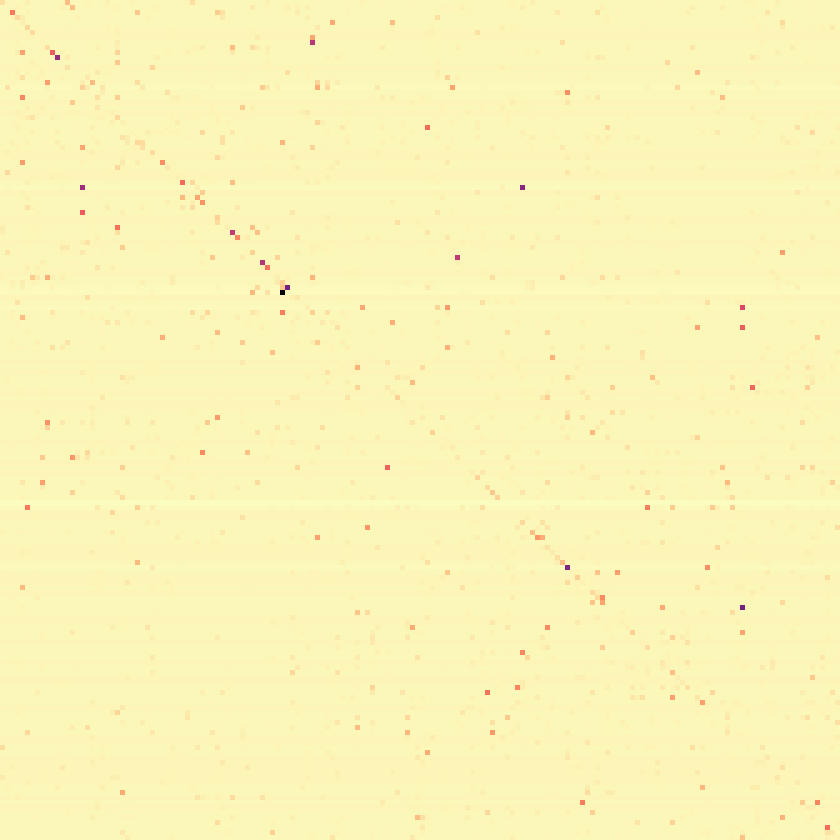

In [ ]:
plot_confusion_matrix_df(
    test_evals.confusion_matrix_prob_df(),
    raw=True, scale=5,
)

In [ ]:
# TODO
#   - Well, these coverage_errors and confusion_matrix results are pretty poor -- not at all competitive with rf given
#     the same amount of train time
#   - Probably need a lot more train time to get good results from gbm -- I guess the point is that you can get better
#     performance from gbm than rf given infinite train time...?